In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [46]:
pd.options.display.float_format = '{:.5f}'.format

In [2]:
aud_data = pd.read_csv('')
con_data = pd.read_csv('')
pay_data = pd.read_csv('')

In [3]:
aud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27061 entries, 0 to 27060
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         27061 non-null  int64  
 1   type           27061 non-null  object 
 2   level_seg      27061 non-null  int64  
 3   sum_cashusage  13417 non-null  float64
 4   gendertype     13417 non-null  object 
 5   age            13417 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


In [4]:
aud_data.head(10)

,userid,type,level_seg,sum_cashusage,gendertype,age
0,35271,target,1,NaN,NaN,NaN
1,43418,target,5,753510.0,여자,54.0
2,12391,target,5,148100.0,남자,27.0
3,68346,target,5,415800.0,여자,26.0
4,2509,target,5,201400.0,남자,36.0
5,55706,target,1,NaN,NaN,NaN
6,34392,target,5,1903400.0,남자,29.0
7,72123,target,2,0.0,남자,31.0
8,97832,target,4,385300.0,남자,25.0
9,55238,target,5,1608800.0,여자,29.0


In [5]:
aud_dupli = aud_data.duplicated(['userid'])

In [6]:
aud_dupli

0        False
1        False
2        False
3        False
4        False
         ...  
27056    False
27057    False
27058    False
27059    False
27060    False
Length: 27061, dtype: bool

In [7]:
aud_data[aud_data.duplicated()]

,userid,type,level_seg,sum_cashusage,gendertype,age


### 위 과정을 통해 userid 중복이 하나도 없다는 것을 확인.

### 먼저 레벨대와 이탈전 유저가 과금한 과금량의 관계성을 찾아보자. 레벨과 과금량이 관계성이 높지 않다면 과금에 대한 허들은 높지 않은 편이라 볼 수 있다. 
### 대략적인 상관관계 확인


In [8]:
corr_aud_data = aud_data.corr()
corr_aud_data = corr_aud_data.apply(lambda x: round(x, 2))
corr_aud_data

,userid,level_seg,sum_cashusage,age
userid,1.00,-0.00,-0.01,0.01
level_seg,-0.00,1.00,0.18,0.07
sum_cashusage,-0.01,0.18,1.00,0.02
age,0.01,0.07,0.02,1.00


### 레벨과 과금량은 0.18로 상관없음을 알 수 있다.

### 이제 메세지 발송 미발송을 나누어 확인하자. 이는 밑에서 con_data, pay_data에서도 참고하여 사용할 것.

In [9]:
is_target = aud_data['type'] == 'target'
target_aud_data = aud_data[is_target] # 메세지 발송 유저집단
is_control = aud_data['type'] == 'control'
control_aud_data = aud_data[is_control] # 메세지 미발송 유저집단

In [10]:
target_aud_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21647 entries, 0 to 21646
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         21647 non-null  int64  
 1   type           21647 non-null  object 
 2   level_seg      21647 non-null  int64  
 3   sum_cashusage  10740 non-null  float64
 4   gendertype     10740 non-null  object 
 5   age            10740 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.2+ MB


In [11]:
control_aud_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5414 entries, 21647 to 27060
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         5414 non-null   int64  
 1   type           5414 non-null   object 
 2   level_seg      5414 non-null   int64  
 3   sum_cashusage  2677 non-null   float64
 4   gendertype     2677 non-null   object 
 5   age            2677 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 296.1+ KB


### ----------------------------------------------------------------------------------------------------
### ----------------------------------------------------------------------------------------------------


### connect data 살펴보자

In [12]:
con_data['sdate'] = pd.to_datetime(con_data['sdate'], format='%Y-%m-%d')
# sdate를 datetime으로 바꿔주자.
con_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831221 entries, 0 to 831220
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   userid         831221 non-null  int64         
 1   sdate          831221 non-null  datetime64[ns]
 2   totalplaytime  831221 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 19.0 MB


In [13]:
con_data.head()

,userid,sdate,totalplaytime
0,87382,2020-11-25,1440
1,87382,2020-11-24,1440
2,87382,2020-11-23,1436
3,87382,2020-11-22,1439
4,87382,2020-11-21,1439


In [14]:
# LMS날짜 기준으로 이전과 이후로 나누자
LMSday = '2020-11-19'
pre_con_data = con_data.query('sdate < @LMSday') # LMS 이전 유저 집단
post_con_data = con_data.query('sdate >= @LMSday') # LMS 이후 유저 집단
# 여기서 다시 해줘야 할 것은, target과 control기준으로 유저를 나누는 것이다. 위에서부터 천천히 해보자.

In [15]:
# userid 기준으로 group by하여 총 playtime을 구하고, pre와 post의 차이를 찾아보자. 
GB_pre_con_data = pre_con_data.groupby('userid')['totalplaytime'].aggregate(['sum']).reset_index()
GB_post_con_data = post_con_data.groupby('userid')['totalplaytime'].aggregate(['sum']).reset_index()

In [16]:
GB_pre_con_data.describe()

,userid,sum
count,75536.000000,75536.000000
mean,57185.597914,1642.448157
std,33099.534319,1977.852836
min,1.000000,0.000000
25%,28428.750000,482.000000
50%,57140.500000,941.000000
75%,85844.250000,2016.250000
max,114546.000000,30152.000000


In [17]:
GB_post_con_data.describe()

,userid,sum
count,80765.000000,80765.000000
mean,57242.664384,1571.433183
std,33072.352534,1856.324958
min,1.000000,0.000000
25%,28557.000000,446.000000
50%,57299.000000,946.000000
75%,85905.000000,1985.000000
max,114550.000000,34218.000000


### 주의할 점 => audience 데이터에 있는 유저는 약 27000명이고, connect에 있는 유저수는 group by를 마치고 나서도 15만명정도 된다. 이를 주의해야 할 것.
- 하지만 LMS 발송여부가 없는 데이터는 의미없을 수 있기 때문에, 이 유저들은 유입량 판단에서만 활용할 수 있을 것.

### 여기서부터 pre와 post간의 sum 차이가 있는지 살펴보는 것도 좋겠다. 아니면 LMS여부를 포함하여 sum차이를 보는것이 더 맞으려나?

In [18]:
# target 유저집단 중, LMS 이'전'connect 데이터에 포함되는 유저들
target_GB_pre_con_data = pd.merge(target_aud_data, GB_pre_con_data, on = 'userid', how = 'inner')
# target 유저집단 중, LMS 이'후' connect 데이터에 포함되는 유저들
target_GB_post_con_data = pd.merge(target_aud_data, GB_post_con_data, on = 'userid', how = 'inner')

In [19]:
target_GB_pre_con_data.describe()

,userid,level_seg,sum_cashusage,age,sum
count,248.000000,248.000000,1.250000e+02,125.000000,248.000000
mean,59809.282258,4.233871,1.311566e+06,32.656000,169.717742
std,33251.842203,1.241058,3.018528e+06,12.224449,398.116162
min,10.000000,1.000000,0.000000e+00,19.000000,0.000000
25%,32538.000000,3.750000,3.250000e+04,25.000000,10.000000
50%,61625.500000,5.000000,2.345000e+05,28.000000,50.000000
75%,89169.750000,5.000000,1.219000e+06,33.000000,177.500000
max,114313.000000,5.000000,2.430690e+07,69.000000,4029.000000


In [20]:
target_GB_post_con_data.describe()

,userid,level_seg,sum_cashusage,age,sum
count,1513.000000,1513.000000,1.114000e+03,1114.000000,1513.000000
mean,58211.447455,4.125578,6.514880e+05,30.689408,461.817581
std,32735.590465,1.291543,1.535742e+06,10.357081,773.869834
min,10.000000,1.000000,0.000000e+00,15.000000,0.000000
25%,30256.000000,3.000000,2.535000e+04,25.000000,32.000000
50%,58753.000000,5.000000,1.404000e+05,27.000000,167.000000
75%,87890.000000,5.000000,6.104710e+05,31.000000,548.000000
max,114543.000000,5.000000,2.430690e+07,83.000000,8241.000000


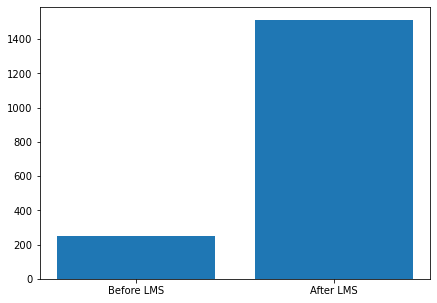

In [21]:
# 유저수 비교하기
x = ['Before LMS', 'After LMS']
y1 = len(target_GB_pre_con_data['userid']) # 당일 플레이 유저 수
y2 = len(target_GB_post_con_data['userid']) # 2일 이후 플레이 유저 수
y = [y1, y2]
plt.figure(figsize=(7, 5))
plt.bar(x, y)
plt.show()

### 오...일단 LMS이후의 표본 크기가 7배정도 크네...?

In [22]:
# control 유저집단 중, LMS 이전 connect 데이터에 포함되는 유저
control_GB_pre_con_data = pd.merge(control_aud_data, GB_pre_con_data, on = 'userid', how = 'inner')
# control 유저집단 중, LMS 이후 connect 데이터에 포함되는 유저
control_GB_post_con_data = pd.merge(control_aud_data, GB_post_con_data, on = 'userid', how = 'inner')

In [23]:
control_GB_pre_con_data.describe()

,userid,level_seg,sum_cashusage,age,sum
count,74.000000,74.000000,4.300000e+01,43.000000,74.000000
mean,56719.891892,4.324324,8.010129e+05,33.162791,114.175676
std,32411.803404,1.159926,1.025618e+06,14.685481,197.571722
min,581.000000,1.000000,0.000000e+00,21.000000,0.000000
25%,33350.500000,4.000000,7.970000e+04,25.000000,10.250000
50%,57263.500000,5.000000,4.241000e+05,29.000000,45.500000
75%,82114.500000,5.000000,9.091500e+05,33.500000,103.250000
max,114524.000000,5.000000,3.736600e+06,90.000000,1055.000000


In [24]:
control_GB_post_con_data.describe()

,userid,level_seg,sum_cashusage,age,sum
count,300.000000,300.000000,2.380000e+02,238.000000,300.000000
mean,57132.366667,4.286667,6.354335e+05,30.701681,450.060000
std,32749.739647,1.203877,1.883036e+06,10.523796,774.106893
min,144.000000,1.000000,0.000000e+00,18.000000,0.000000
25%,32094.750000,4.000000,2.731950e+04,24.250000,27.750000
50%,57994.000000,5.000000,1.319000e+05,27.000000,136.000000
75%,85396.500000,5.000000,5.827425e+05,32.000000,562.000000
max,114418.000000,5.000000,2.509210e+07,78.000000,5099.000000


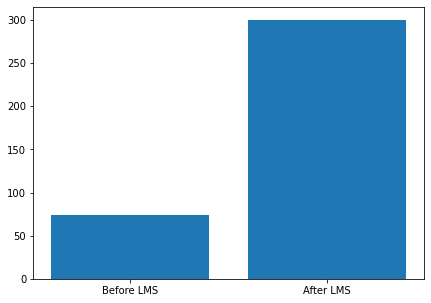

In [25]:
# 유저수 비교하기
x = ['Before LMS', 'After LMS']
y1 = len(control_GB_pre_con_data['userid']) # 당일 플레이 유저 수
y2 = len(control_GB_post_con_data['userid']) # 2일 이후 플레이 유저 수
y = [y1, y2]
plt.figure(figsize=(7, 5))
plt.bar(x, y)
plt.show()

### control에서도 LMS이후 표본이 더 크다. 4배정도. 
- 아마 입소문을 듣고 다시 복귀한 것이 아닐까 생각해볼 수 있다.

### 지금까지의 내용을 통해(표본의 증가) LMS가 플레이어에게 게임을 유도하였다고 가정해볼 수 있다.
### 위 내용을 그래프로 나타내보자. (아마 막대그래프)
### 유저 표본의 크기 증가, 즉 유저수 증가를 여기서 그래프로 보고 복귀 성공을 가정하였다
### 바로 밑에서 유저들을 target과 control로 만 나눈 상태를 보고 간단한 AB테스트를 활용하여 playtime은 type에 따라 어떻게 다른지 확인해 볼 것.

In [26]:
# LMS이후 유저중 target 유저의 평균 플레이 시간
np.mean(target_GB_post_con_data['sum'])

461.81758096497026

In [27]:
# LMS이후 유저중 control 유저의 평균 플레이 시간
np.mean(control_GB_post_con_data['sum'])

450.06

### 평균 플레이시간의 차이가 약 12정도가 있는 걸 확인할 수 있다. 이 차이가 LMS로 인해 발생한 유의미한 차이인지 확인해보았다.

In [28]:
# ab테스트 진행
A = target_GB_post_con_data['sum']
B = control_GB_post_con_data['sum']
stats.ttest_ind(A, B, equal_var=False) # 수치형 데이터이기 때문에 t-test사용

Ttest_indResult(statistic=0.24033677973943737, pvalue=0.8101848142843328)

### pvalue가 0.05가 넘는 0.8의 값을 보여주기 때문에 '두 집단 간 차이가 없을 것이다'라는 가설을 채택할 수 있으며, LMS로 인한 플레이타임의 차이는 없다고 볼 수 있다.

### 좀 더 살펴보기위해 
1. LMS날짜 기준으로 하루 후의 플레이타임과, 2일 이후 플레이 타임과 유저수를 비교해보고, 이 LMS가 휘발성 이벤트인지, 아니면 확실하게 유저들의 복귀를 만들어냈는지 평가할 수 있겠다. 그리고 반드시 target 집단 중에 확인해 볼 것.

In [29]:
LMSday = '2020-11-19'
LMSday_con_data = con_data.query('sdate == @LMSday') #LMS 당일 유저 집단
afterLMS_con_data = con_data.query('sdate > @LMSday') #LMS 2일 이후 유저 집단

# group by
GB_LMSday_con_data = LMSday_con_data.groupby('userid')['totalplaytime'].aggregate(['sum']).reset_index()
GB_afterLMS_con_data = afterLMS_con_data.groupby('userid')['totalplaytime'].aggregate(['mean']).reset_index()

# 여기서 target 집단과 inner join 해야한다.
target_GB_LMSday_con_data = pd.merge(target_aud_data, GB_LMSday_con_data, on = 'userid', how = 'inner')
target_GB_afterLMS_con_data = pd.merge(target_aud_data, GB_afterLMS_con_data, on = 'userid', how = 'inner')

# 위에서 2일 뒤 플레이타임의 '감소량'도 볼 수 있으면 좋을것 같다.

# 여기서 totalplaytime sum 구해서 막대그래프로 비교해보자.

# 그리고나서 당일유저집단과 2일 이후 유저집단의 플레이타임과 유저수를 비교하여 유저 몰입이 얼마나 유지되는지 살펴볼 것.


In [30]:
target_GB_LMSday_con_data

,userid,type,level_seg,sum_cashusage,gendertype,age,sum
0,61224,target,5,NaN,NaN,NaN,376
1,35417,target,5,NaN,NaN,NaN,48
2,114048,target,2,NaN,NaN,NaN,1
3,102224,target,4,2000.0,여자,23.0,137
4,39705,target,5,4027160.0,남자,31.0,91
...,...,...,...,...,...,...,...
329,68180,target,5,50300.0,여자,24.0,55
330,84279,target,5,919100.0,남자,30.0,84
331,23448,target,4,NaN,NaN,NaN,139
332,109183,target,5,0.0,남자,26.0,84


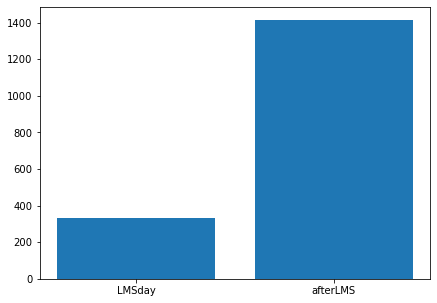

In [31]:
# 유저수 비교하기
x = ['LMSday', 'afterLMS']
y1 = len(target_GB_LMSday_con_data['userid']) # 당일 플레이 유저 수
y2 = len(target_GB_afterLMS_con_data['userid']) # 2일 이후 플레이 유저 수
y = [y1, y2]
plt.figure(figsize=(7, 5))
plt.bar(x, y)
plt.show()

### LMS기준 당일엔 334명, 이후에 1414명으로 유저 수가 증가하였다.
- 이를 보고 유저 유입이 성공적이었다고 가정할 수 있다.

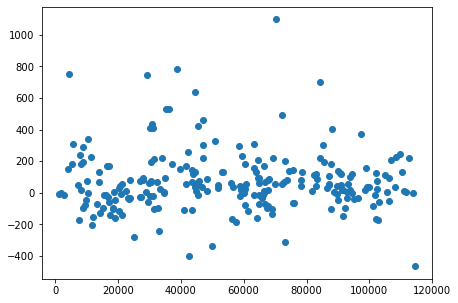

In [32]:
# 플레이 타임 비교하기
# 2일 뒤 플레이타임은 평균을 구해서 비교하였다
# 먼저 두 데이터를 합친다. 공통으로 가지는 userid만 뽑기위해 inner조건 사용
LMSday_afterLMS_condata = pd.merge(target_GB_LMSday_con_data, target_GB_afterLMS_con_data, on = 'userid', how = 'inner')


x_value = LMSday_afterLMS_condata['userid']
y_value = LMSday_afterLMS_condata['mean'] - LMSday_afterLMS_condata['sum']
plt.figure(figsize=(7, 5))
plt.scatter(x_value, y_value)
plt.show()

### 위 산점도를 통해 알수있는것
1. LMS 당일 플레이시간 보다 2일 이후 평균 플레이시간이 높거나 비슷한 유저들은 LMS로 인해 흥미를 느껴 게임에 몰입하게 된 경우라고 볼 수 있다.
2. 2일 이후 평균 플레이시간이 당일 플레이시간보다 적은 경우는 LMS가 복귀를 성공시키지 못한 유저들이라 볼 수 있다. 이에 이 유저들을 보고, 플레이시간의 감소 현황을 그래프로 살펴보려 한다

In [33]:
# 2일 이후 평균 플레이시간이 증가 혹은 유지되는 유저들, 즉 (2일 이후 평균 플레이 시간 - 당일 플레이 시간)이 양수, 0인 경우
increase_condition = LMSday_afterLMS_condata['mean'] - LMSday_afterLMS_condata['sum'] >= 0
increase_playtime_users = LMSday_afterLMS_condata[increase_condition]
len(increase_playtime_users)

154

In [34]:
# 2일 이후 평균 플레이시간이 감소하는 유저들, 즉 (2일 이후 평균 플레이 시간 - 당일 플레이 시간)이 음수인 경우
decrease_condition = LMSday_afterLMS_condata['mean'] - LMSday_afterLMS_condata['sum'] < 0
decrease_playtime_users = LMSday_afterLMS_condata[decrease_condition]
len(decrease_playtime_users)

81

### 먼저 약 3배 이상의 유저 규모가 복귀에 성공했다고 가정할 수 있다.
### 이제 복귀에 실패한 81명의 유저에 대해 중점적으로 특성을 파악해보고, 어떤 특성이 LMS실패의 원인이 되었을지 추측해보자.

In [35]:
decrease_playtime_users

,userid,type_x,level_seg_x,sum_cashusage_x,gendertype_x,age_x,sum,type_y,level_seg_y,sum_cashusage_y,gendertype_y,age_y,mean
0,61224,target,5,NaN,NaN,NaN,376,target,5,NaN,NaN,NaN,258.666667
2,114048,target,2,NaN,NaN,NaN,1,target,2,NaN,NaN,NaN,0.000000
8,11793,target,1,NaN,NaN,NaN,256,target,1,NaN,NaN,NaN,49.500000
16,18270,target,4,10900.0,남자,27.0,139,target,4,10900.0,남자,27.0,43.000000
17,92320,target,5,35760.0,남자,31.0,153,target,5,35760.0,남자,31.0,54.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,64843,target,5,174100.0,남자,26.0,74,target,5,174100.0,남자,26.0,57.000000
223,68993,target,5,67.0,남자,27.0,160,target,5,67.0,남자,27.0,58.000000
225,32944,target,5,19310.0,여자,24.0,356,target,5,19310.0,여자,24.0,116.000000
230,20820,target,2,NaN,NaN,NaN,60,target,2,NaN,NaN,NaN,50.000000


In [36]:
# 먼저 decrease_playtime_users에서 필요없는, 중복되는 columns들 drop
decrease_playtime_users = decrease_playtime_users.drop(['type_y', 'level_seg_y', 'sum_cashusage_y', 'gendertype_y', 'age_y'], axis = 1)
decrease_playtime_users

,userid,type_x,level_seg_x,sum_cashusage_x,gendertype_x,age_x,sum,mean
0,61224,target,5,NaN,NaN,NaN,376,258.666667
2,114048,target,2,NaN,NaN,NaN,1,0.000000
8,11793,target,1,NaN,NaN,NaN,256,49.500000
16,18270,target,4,10900.0,남자,27.0,139,43.000000
17,92320,target,5,35760.0,남자,31.0,153,54.500000
...,...,...,...,...,...,...,...,...
216,64843,target,5,174100.0,남자,26.0,74,57.000000
223,68993,target,5,67.0,남자,27.0,160,58.000000
225,32944,target,5,19310.0,여자,24.0,356,116.000000
230,20820,target,2,NaN,NaN,NaN,60,50.000000


### 기준
1. 모든 유저의 평균적인 레벨과 decrease유저의 평균적인 레벨 차이
2. 모든 유저의 평균적인 과금량과 decrease유저의 평균적인 과금량 차이
3. 모든 유저의 평균적인 플레이 시간과 decrease유저의 평균적인 플레이 시간 차이
### 위 기준 3가지를 먼저 살펴보자.
### 그리고 현재 decrease_playtime_users 데이터는 LMS 발송 이전 데이터가 포함되어있지 않다. 이를 포함시켜주고 특성을 파악해 볼 것.
### LMS이전의 활동 데이터를 통해 decrease 유저들은 어떤 특성을 가지고 있었고, 이 특성들이 다른 유저들과 어떻게 다른지 확인해보자.

In [37]:
decrease_playtime_users.describe()

,userid,level_seg_x,sum_cashusage_x,age_x,sum,mean
count,81.000000,81.000000,5.700000e+01,57.000000,81.000000,81.000000
mean,49880.296296,4.320988,6.692817e+05,29.035088,212.037037,121.623251
std,32724.811314,1.222980,8.740328e+05,9.626906,168.395921,116.815261
min,1380.000000,1.000000,0.000000e+00,15.000000,1.000000,0.000000
25%,19112.000000,4.000000,3.576000e+04,24.000000,99.000000,47.333333
50%,45542.000000,5.000000,2.633000e+05,27.000000,169.000000,95.000000
75%,69001.000000,5.000000,1.162300e+06,30.000000,293.000000,166.333333
max,114382.000000,5.000000,3.927600e+06,63.000000,1014.000000,614.400000


In [38]:
GB_pre_aud_con_data = pd.merge(aud_data, GB_pre_con_data, on = 'userid', how = 'inner')
GB_post_aud_con_data = pd.merge(aud_data, GB_post_con_data, on = 'userid', how = 'inner')

In [39]:
GB_pre_aud_con_data

,userid,type,level_seg,sum_cashusage,gendertype,age,sum
0,61224,target,5,NaN,NaN,NaN,270
1,35417,target,5,NaN,NaN,NaN,751
2,577,target,5,145790.0,남자,58.0,123
3,42115,target,5,260300.0,여자,19.0,223
4,78344,target,3,NaN,NaN,NaN,44
...,...,...,...,...,...,...,...
317,28994,control,5,3187700.0,남자,29.0,8
318,58871,control,5,2891400.0,남자,21.0,156
319,9594,control,5,NaN,NaN,NaN,8
320,56544,control,3,NaN,NaN,NaN,59


In [40]:
GB_post_aud_con_data

,userid,type,level_seg,sum_cashusage,gendertype,age,sum
0,12391,target,5,148100.0,남자,27.0,28
1,61224,target,5,NaN,NaN,NaN,1928
2,100667,target,5,3037800.0,남자,30.0,1500
3,35417,target,5,NaN,NaN,NaN,3513
4,114048,target,2,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...
1808,32280,control,5,690000.0,여자,20.0,108
1809,59068,control,5,25092100.0,남자,26.0,51
1810,8711,control,5,50600.0,남자,34.0,694
1811,107392,control,5,19380.0,남자,26.0,32


In [81]:
# LMS 여부상관없이 모든 유저들의 데이터를 보기위해 group by된 connect데이터를 사용할 것.

# group by 된 데이터(GB_pre_con_data, GB_post_con_data)와 audience 데이터를 userid기준으로 inner join을 한다.
GB_pre_aud_con_data = pd.merge(aud_data, GB_pre_con_data, on = 'userid', how = 'inner')
GB_post_aud_con_data = pd.merge(aud_data, GB_post_con_data, on = 'userid', how = 'inner')


# 이제 decrease 유저 데이터의 pre, 즉 lMS이전 데이터를 구해준다.
#LMS 이전 decrease 유저 집단
pre_decrease_playtime_users = pd.merge(decrease_playtime_users, GB_pre_con_data, on = 'userid', how = 'inner')

# decrease 유저 집단중 LMS 이후 데이터는 위에서 이미 구해둔 decrease_playtime_users데이터이다.

# 총 4개의 데이터 프레임이 준비되었다. connect와 audienct를 합친 데이터를 LMS기준으로 나눈 두 데이터와, decrease 유저 데이터를 LMS기준으로 나눈 두 데이터.
# (GB_pre_aud_con_data, pre_decrease_playtime_users)와 (GB_post_aud_con_data, decrease_playtime_users)를 비교해볼것.

In [82]:
# 먼저 GB_pre_aud_con_data와 pre_decrease_playtime_users 보자
# 발표자료를 위해 컬럼명 변경.
GB_pre_aud_con_data.rename(columns = {'sum':'sum_totalplaytime'}, inplace=True)
GB_pre_aud_con_data.describe()

,userid,level_seg,sum_cashusage,age,sum_totalplaytime
count,322.00000,322.00000,168.00000,168.00000,322.00000
mean,59099.29814,4.25466,1180889.07738,32.78571,156.95342
std,33036.20643,1.22171,2660812.09837,12.85485,362.46807
min,10.00000,1.00000,0.00000,19.00000,0.00000
25%,32842.75000,4.00000,39750.00000,25.00000,10.00000
50%,60792.00000,5.00000,321260.00000,28.00000,49.00000
75%,87881.00000,5.00000,1077900.00000,33.25000,160.75000
max,114524.00000,5.00000,24306900.00000,90.00000,4029.00000


In [83]:
# 주의할 것. merge 과정에서 생긴 sum_x와 mean column은 drop해야한다. 이는 LMS 당일 플레이타임과 LMS 이후 플레이 타임의 값이기 때문.
pre_decrease_playtime_users = pre_decrease_playtime_users.drop(['sum_x', 'mean'], axis = 1)
pre_decrease_playtime_users.rename(columns = {'level_seg_x':'level_seg', 'sum_cashusage_x':'sum_cashusage', 'age_x':'age', 'sum_y':'sum_totalplaytime'}, inplace=True)
pre_decrease_playtime_users.describe()

,userid,level_seg,sum_cashusage,age,sum_totalplaytime
count,24.00000,24.00000,12.00000,12.00000,24.00000
mean,48733.37500,4.37500,917684.33333,30.58333,416.41667
std,30313.87081,1.20911,1140208.52132,9.35617,838.05198
min,2676.00000,1.00000,100.00000,23.00000,1.00000
25%,22873.75000,4.75000,46800.00000,26.00000,29.00000
50%,49372.50000,5.00000,658670.00000,29.00000,117.00000
75%,65423.25000,5.00000,1286827.50000,31.00000,463.00000
max,102144.00000,5.00000,3927600.00000,59.00000,4029.00000


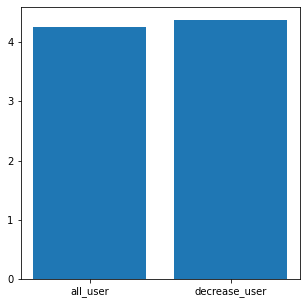

In [70]:
x = ['all_user', 'decrease_user']
#y1 = np.array(df1_GB_con_data['num_items'])
#y2 = np.array(df1_GB_con_data['counts'])
y1 = np.mean(GB_pre_aud_con_data['level_seg'])
y2 = np.mean(pre_decrease_playtime_users['level_seg'])
y = [y1, y2]
plt.figure(figsize=(5, 5))
plt.bar(x, y)
plt.show()

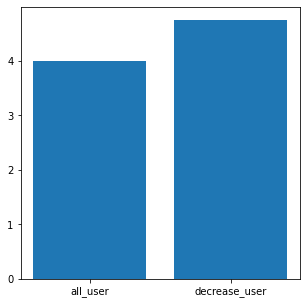

In [74]:
x = ['all_user', 'decrease_user']
#y1 = np.array(df1_GB_con_data['num_items'])
#y2 = np.array(df1_GB_con_data['counts'])
y1 = GB_pre_aud_con_data['level_seg'].quantile(.25)
y2 = pre_decrease_playtime_users['level_seg'].quantile(.25)
y = [y1, y2]
plt.figure(figsize=(5, 5))
plt.bar(x, y)
plt.show()

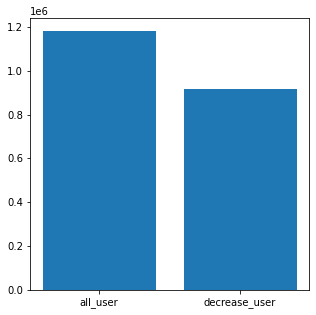

In [75]:
x = ['all_user', 'decrease_user']
#y1 = np.array(df1_GB_con_data['num_items'])
#y2 = np.array(df1_GB_con_data['counts'])
y1 = np.mean(GB_pre_aud_con_data['sum_cashusage'])
y2 = np.mean(pre_decrease_playtime_users['sum_cashusage'])
y = [y1, y2]
plt.figure(figsize=(5, 5))
plt.bar(x, y)
plt.show()

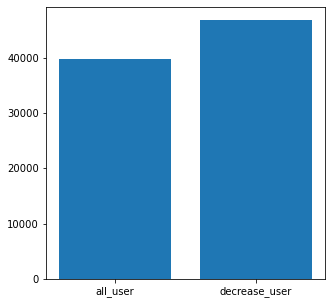

In [76]:
x = ['all_user', 'decrease_user']
#y1 = np.array(df1_GB_con_data['num_items'])
#y2 = np.array(df1_GB_con_data['counts'])
y1 = GB_pre_aud_con_data['sum_cashusage'].quantile(.25)
y2 = pre_decrease_playtime_users['sum_cashusage'].quantile(.25)
y = [y1, y2]
plt.figure(figsize=(5, 5))
plt.bar(x, y)
plt.show()

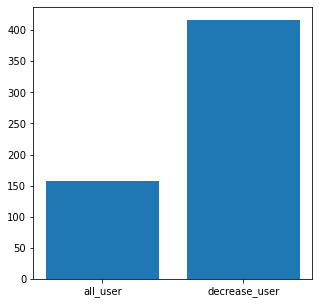

In [84]:
x = ['all_user', 'decrease_user']
#y1 = np.array(df1_GB_con_data['num_items'])
#y2 = np.array(df1_GB_con_data['counts'])
y1 = np.mean(GB_pre_aud_con_data['sum_totalplaytime'])
y2 = np.mean(pre_decrease_playtime_users['sum_totalplaytime'])
y = [y1, y2]
plt.figure(figsize=(5, 5))
plt.bar(x, y)
plt.show()

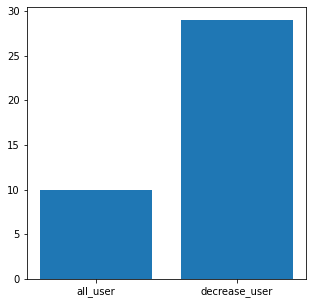

In [85]:
x = ['all_user', 'decrease_user']
#y1 = np.array(df1_GB_con_data['num_items'])
#y2 = np.array(df1_GB_con_data['counts'])
y1 = GB_pre_aud_con_data['sum_totalplaytime'].quantile(.25)
y2 = pre_decrease_playtime_users['sum_totalplaytime'].quantile(.25)
y = [y1, y2]
plt.figure(figsize=(5, 5))
plt.bar(x, y)
plt.show()

### level_seg와 sum_cashusage, age, playtime 등을 볼수 있다. 각 지표들의 평균, 중앙값 등을 활용해 각 집단의 차이를 정리해보자.

### 정리
1. 먼저 decrease유저들은 유저들에 비해 상대적으로 레벨이 높은 것을 볼 수 있다. 평균적으로 0.15정도 레벨이 높은 것을 볼 수 있고, 상위 75%의 유저 레벨은 0.75까지 차이나는 것을 볼 수 있다.
2. 총 플레이시간을 나타내는 sum과 sum_y는 큰차이를 보였다. 모든 유저의 평균 플레이시간이 156을 나타낼때, decrease유저는 평균 416을 나타내었다.
- 결론적으로 decrease유저는 기존 유저들 중 몰입도가 상위권인 유저였다고 볼 수 있다.
- 즉 상위권 유저들에게 효과가 상대적으로 적은 LMS였다고 판단할 수 있다.
- 이제 GB_pre_aud_con_data와 GB_post_aud_con_data의 차이점을 보고, LMS가 가져온 영향을 살펴보도록 하자.
- 이후 해당 지표들이 decrease에게 어떤 영향을 끼쳤을 지 생각해볼 것.

In [86]:
# GB_pre_aud_con_data, GB_post_aud_con_data 비교
GB_pre_aud_con_data.rename(columns = {'sum':'sum_totalplaytime'}, inplace=True)
GB_pre_aud_con_data.describe()

,userid,level_seg,sum_cashusage,age,sum_totalplaytime
count,322.00000,322.00000,168.00000,168.00000,322.00000
mean,59099.29814,4.25466,1180889.07738,32.78571,156.95342
std,33036.20643,1.22171,2660812.09837,12.85485,362.46807
min,10.00000,1.00000,0.00000,19.00000,0.00000
25%,32842.75000,4.00000,39750.00000,25.00000,10.00000
50%,60792.00000,5.00000,321260.00000,28.00000,49.00000
75%,87881.00000,5.00000,1077900.00000,33.25000,160.75000
max,114524.00000,5.00000,24306900.00000,90.00000,4029.00000


In [87]:
GB_post_aud_con_data.rename(columns = {'sum':'sum_totalplaytime'}, inplace=True)
GB_post_aud_con_data.describe()

,userid,level_seg,sum_cashusage,age,sum_totalplaytime
count,1813.00000,1813.00000,1352.00000,1352.00000,1813.00000
mean,58032.89024,4.15223,648661.84246,30.69157,459.87204
std,32731.34979,1.27853,1601587.38036,10.38270,773.70774
min,10.00000,1.00000,0.00000,15.00000,0.00000
25%,30362.00000,3.00000,25650.00000,25.00000,31.00000
50%,58708.00000,5.00000,140400.00000,27.00000,164.00000
75%,87286.00000,5.00000,606175.00000,31.00000,554.00000
max,114543.00000,5.00000,25092100.00000,83.00000,8241.00000


### 정리
1. 먼저 유저의 수가 6배 가량 늘어난 것을 볼 수 있다. 
2. 전체적인 레벨의 평균이 내려갔으며, 상위 75%의 레벨이 4에서 3으로 내려간 것을 볼 수 있다.
3. 위 결과를 통해 낮은 레벨대에 발송한 복귀유도 메시지가 더 효과적으로 작용했다고 볼 수 있다.

### level_seg와 sum_cashusage, age, playtime 등을 볼수 있다. 각 지표들의 평균, 중앙값 등을 활용해 각 집단의 차이를 정리해보자.

### ----------------------------------------------------------------------------------------------------
### ----------------------------------------------------------------------------------------------------

In [47]:
pay_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31641 entries, 0 to 31640
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userid     31641 non-null  int64  
 1   sdate      31641 non-null  object 
 2   itemno     31637 non-null  float64
 3   payamount  31641 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 988.9+ KB


In [48]:
pay_data.describe()

,userid,itemno,payamount
count,31641.000000,31637.000000,3.164100e+04
mean,57373.437123,505308.377438,2.413133e+04
std,32951.765156,49239.659511,5.524359e+04
min,7.000000,448748.000000,0.000000e+00
25%,28606.000000,448804.000000,2.900000e+03
50%,57901.000000,510344.000000,1.000000e+04
75%,85289.000000,554101.000000,2.270000e+04
max,114546.000000,554530.000000,2.062900e+06


### 과금량과 플레이 타임의 연관성을 먼저 살펴보도록 한다.

### 포인트
1. 특정 item이 많이 팔리는게 있는지 찾아볼 것. 예를 들어 시즌패스나, 일주일 단위로 새로 나오는 아이템 등
2. LMS 이후 판매가 증가한 item이 있는지 살펴보자. 특정 아이템을 할인하는 이벤트였을 가능성이 있기 때문. 만약 그렇다면, decrease유저가 평소에 많이 사던 item인지도 확인. 이 item의 파격적 할인으로 인해 과금유저가 차별성을 갖지 못한다고 생각하여 이탈하게 된 것일수 있음.
3. 그리고 LMS 기준으로 과금 유저 수가 늘어났는지 확인해보자. 늘어났다면 과금에 대한 허들이 낮아져서 많은 유저가 가볍게 과금하는 것일 수 있다. 줄어들었다면 무과금 유저가 게임을 즐기기 수월해졌다는 것으로 볼 수 있다.

In [49]:
pip install -U pandasql

Requirement already up-to-date: pandasql in c:\users\dhckd\anaconda3\lib\site-packages (0.7.3)
Note: you may need to restart the kernel to use updated packages.


In [50]:
from pandasql import *

In [51]:
# 1.날짜를 기준으로 item을 count 해보자
q = "SELECT sdate, count(itemno) as num_items FROM pay_data GROUP BY sdate ORDER BY sdate"
'''q = "SELECT 
        sdate,
        count(itemno) as num_items
    FROM pay_data
    GROUP BY sdate
    ORDER BY sdate
    "
    '''
    
df1 = sqldf(q)

In [52]:
df1

,sdate,num_items
0,2020-11-12,1637
1,2020-11-13,1634
2,2020-11-14,2011
3,2020-11-15,2193
4,2020-11-16,1528
5,2020-11-17,1405
6,2020-11-18,1648
7,2020-11-19,6169
8,2020-11-20,3063
9,2020-11-21,2863


### 날짜별 유저규모와 날짜별 아이템 판매량의 증감 확인해볼 것.
- 유저 규모는 총 게임 내 유저를 확인해야하기 때문에 connect를 활용하여 구한다.

In [55]:
GB_con_data = con_data.groupby('sdate').size().reset_index(name='counts')

#con_data.groupby('sdate')['totalplaytime'].aggregate(['sum']).reset_index()

In [56]:
GB_con_data

,sdate,counts
0,2020-11-12,58077
1,2020-11-13,57845
2,2020-11-14,59256
3,2020-11-15,60448
4,2020-11-16,58332
5,2020-11-17,58005
6,2020-11-18,57868
7,2020-11-19,58054
8,2020-11-20,59566
9,2020-11-21,61562


In [58]:
# sdate를 datetime으로 바꿔주자. connect에서 sdate는 이미 바뀌어 있으니.
df1['sdate'] = pd.to_datetime(df1['sdate'], format='%Y-%m-%d')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sdate      14 non-null     datetime64[ns]
 1   num_items  14 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 352.0 bytes


In [59]:
# df1이랑 GB_con_data를 합쳐서 그래프로 나타내보자
df1_GB_con_data = pd.merge(df1, GB_con_data, on = 'sdate', how = 'inner')

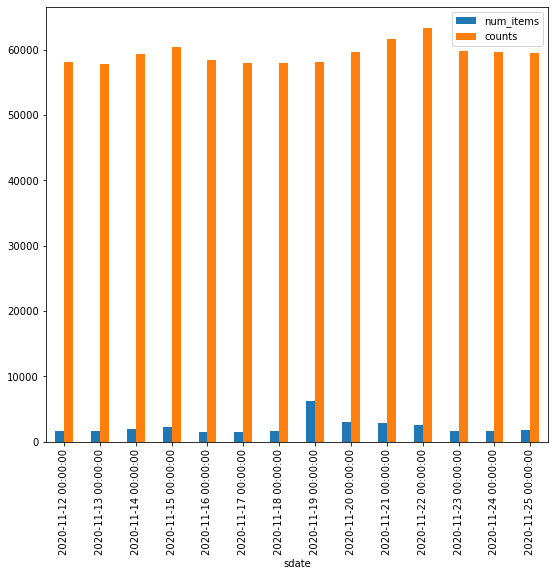

In [62]:
df1_GB_con_data.plot(x = 'sdate', y = ['num_items', 'counts'], kind = 'bar', figsize=(9,8))
plt.show()

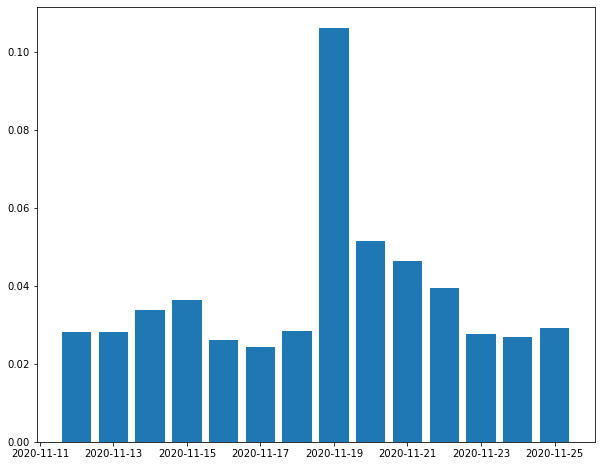

In [81]:
# 날짜별 아이템 판매량과 유저 수 비율 그래프
x = df1_GB_con_data['sdate']
y1 = np.array(df1_GB_con_data['num_items'])
y2 = np.array(df1_GB_con_data['counts'])
y_value = y1/y2
plt.figure(figsize=(10, 8))
plt.bar(x, y_value)
plt.show()

### 위 쿼리 결과를 보고 LMS발송일인 2020-11-19에 아이템 판매가 6169건으로 급증한 것을 볼 수 있다.
- 그렇기에 LMS가 현금성 이벤트였다는 것을 추론해볼 수 있다.
- 2020-11-19에 가장 많이 팔린 아이템을 찾아보자

In [105]:
q = "SELECT itemno, count(itemno) as num_each_items FROM pay_data WHERE sdate == '2020-11-19' GROUP BY itemno ORDER BY num_each_items DESC LIMIT 10"

'''q = "SELECT 
        itemno,
        count(itemno) as num_each_items
    FROM pay_data
    WHERE sdate == '2020-11-19'
    GROUP BY itemno
    ORDER BY num_each_items DESC
    LIMIT 10
    "
    '''
df2 = sqldf(q)

In [106]:
df2

,itemno,num_each_items
0,554105.0,1749
1,554101.0,1028
2,554103.0,836
3,554102.0,812
4,554104.0,319
5,449900.0,198
6,448753.0,141
7,448804.0,132
8,483954.0,130
9,448752.0,105


### LMS 발송 당일 가장 많이 팔린 아이템 10개를 조회하였다.
1. 가장 많이 팔린 아이템은 554105.0이다.
2. 팔린 양이 10배 이상 차이나는 아이템은 제외하고 선정해보았다. (0~5까지 선정)
3. 위에서 선정한 6가지 item이 decrease유저가 많이 사던 아이템이라면, 해당 아이템에 한해서 이벤트가 진행되었고, 이 이벤트로 인해 decrease유저가 발생하였다고 가정해볼 수 있다.
4. 이를 확인하기 위해 LMS 이전의 decrease유저 집단과 payment 데이터를 함께 확인해보았다.

### ##################################################################
### ##################################################################

In [237]:
# 먼저 payment 데이터로 각 유저별 가장 많이 사는 아이템이 무엇인지 찾아보자
q = "SELECT userid, (SELECT itemno FROM pay_data GROUP BY itemno ORDER BY count(itemno) desc LIMIT 1) as max_itemno FROM pay_data GROUP BY userid ORDER BY max_itemno"

"""
q = "SELECT userid, (SELECT userid, itemno, count(itemno) as count_item
                     FROM pay_data
                     GROUP BY itemno
                     ORDER BY count_item desc
                     LIMIT 1)
    FROM pay_data
    GROUP BY userid

"
"""
df3 = sqldf(q)

In [238]:
df3

,userid,max_itemno
0,7,554105.0
1,20,554105.0
2,24,554105.0
3,32,554105.0
4,39,554105.0
...,...,...
12703,114506,554105.0
12704,114511,554105.0
12705,114512,554105.0
12706,114519,554105.0


### payment의 모든 유저가 게임 플레이를 하며 554105.0 아이템을 가장 많이 산 걸 볼 수 있다. 
### (max_itemno는 해당 유저가 가장 많이 산 아이템)
- 위 내용을 바탕으로 554105.0 아이템이 과금유저에게 필수적인 아이템이라고 볼 수 있다.
- 그렇다면 decrease 유저들에게 554105.0 아이템의 이벤트가 아닌 다른 아이템의 이벤트를 부여하여 복귀를 돕는 전략을 찾아보자.

### ##################################################################
### ##################################################################
### 위 내용 커트

# 장바구니 분석
- 554105.0 아이템과 함께 자주 구매되는 아이템을 찾아보자. 
- 해당 아이템을 통해 이벤트를 진행하여 decrease 유저들의 복귀 전략을 제시해볼 것

In [153]:
# 먼저 LMS 이전 기간의 payment를 토대로 분석할 것.
LMSday = '2020-11-19'
pre_pay_data = pay_data.query('sdate < @LMSday') #LMS 이전 유저 집단
pre_pay_data.describe()

# 554105.0 아이템을 한번이라도 구매한 이력이 있는 유저만 뽑아보자.
item554105 = "itemno in [554105.0, 554101.0, 554103.0, 554102.0, 554104.0]"
item_pre_pay_data = pre_pay_data.query(item554105) #LMS 이전 유저 집단
#item_pre_pay_data

In [154]:
pre_pay_data.describe()

,userid,itemno,payamount
count,12060.000000,12056.000000,1.206000e+04
mean,57310.244776,493228.398059,1.950348e+04
std,33037.307693,48008.681483,4.485731e+04
min,24.000000,448748.000000,0.000000e+00
25%,28334.000000,448804.000000,2.400000e+03
50%,57641.500000,473670.000000,8.400000e+03
75%,85614.250000,553958.000000,2.000000e+04
max,114546.000000,554105.000000,1.050000e+06


In [152]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6169 entries, 8 to 25083
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   userid      6169 non-null   int64  
 1   sdate       6169 non-null   object 
 2   itemno      6169 non-null   object 
 3   payamount   6169 non-null   float64
 4   new_itemno  6169 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 289.2+ KB


In [186]:
# 2020-11-19
# LMS 이후 데이터 확인
day = '2020-11-19'
df = pay_data.query('sdate == @day')

# decrease유저들 중 LMS이전 데이터와 2020-11-12날짜의 데이터 합병(inner)
# temp_df = pd.merge(pre_decrease_playtime_users, df_2020_11_12, on = 'userid', how = 'inner')

# 그리고 itemno를 먼저 str형태로 바꿔줘야한다.
temp_df = df.astype({'itemno':'str'})

# 앞 3자리 떼어내기
new_col = []
for i in range(len(temp_df['itemno'])):
    new_col.append(list(temp_df['itemno'])[i][:3])
    
temp_df.insert(4, "new_itemno", new_col, True)
temp_df

,userid,sdate,itemno,payamount,new_itemno
8,15987,2020-11-19,554101.0,4800.0,554
9,15987,2020-11-19,554105.0,84200.0,554
19,99277,2020-11-19,554103.0,22700.0,554
51,73106,2020-11-19,483954.0,3900.0,483
69,99182,2020-11-19,554105.0,42100.0,554
...,...,...,...,...,...
25078,109028,2020-11-19,554101.0,3600.0,554
25080,34445,2020-11-19,553354.0,0.0,553
25081,34445,2020-11-19,554101.0,0.0,554
25082,103433,2020-11-19,553357.0,24800.0,553


In [188]:
temp_df_r1 = temp_df.groupby(['userid']).apply(lambda x: ','.join(x['new_itemno']))
temp_df_r2 = pd.DataFrame(temp_df_r1).reset_index().rename(columns={0:'new_itemno'})
temp_df_r2

,userid,new_itemno
0,24,554
1,84,554
2,102,554
3,132,554
4,138,"449,554"
...,...,...
4334,114335,"554,554,554"
4335,114357,554
4336,114464,554
4337,114489,448


In [189]:
te = TransactionEncoder()
te_ary = te.fit(temp_df_r2).transform(temp_df_r2)
te_result = pd.DataFrame(te_ary, columns = te.columns_)
te_result

,_,d,e,i,m,n,o,r,s,t,u,w
0,False,True,True,True,False,False,False,True,True,False,True,False
1,True,False,True,True,True,True,True,False,False,True,False,True
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4334,False,False,False,False,False,False,False,False,False,False,False,False
4335,False,False,False,False,False,False,False,False,False,False,False,False
4336,False,False,False,False,False,False,False,False,False,False,False,False
4337,False,False,False,False,False,False,False,False,False,False,False,False


In [192]:
apr_result = apriori(te_result, min_support=0.0001, use_colnames=True)
apr_result

,support,itemsets
0,0.000230,(_)
1,0.000230,(d)
2,0.000461,(e)
3,0.000461,(i)
4,0.000230,(m)
...,...,...
310,0.000230,"(i, e, o, n, w, t, _)"
311,0.000230,"(e, o, m, n, w, t, _)"
312,0.000230,"(i, o, m, n, w, t, _)"
313,0.000230,"(i, e, o, m, n, w, t)"


In [120]:
temp_df

,userid,sdate,itemno,payamount
8,15987,2020-11-19,554101.0,4800.0
9,15987,2020-11-19,554105.0,84200.0
19,99277,2020-11-19,554103.0,22700.0
51,73106,2020-11-19,483954.0,3900.0
69,99182,2020-11-19,554105.0,42100.0
...,...,...,...,...
25078,109028,2020-11-19,554101.0,3600.0
25080,34445,2020-11-19,553354.0,0.0
25081,34445,2020-11-19,554101.0,0.0
25082,103433,2020-11-19,553357.0,24800.0


In [286]:
pre_decrease_playtime_users

,userid,type_x,level_seg_x,sum_cashusage_x,gendertype_x,age_x,sum_y
0,61224,target,5,NaN,NaN,NaN,270
1,11793,target,1,NaN,NaN,NaN,146
2,26929,target,3,NaN,NaN,NaN,1
3,16258,target,5,100.0,여자,31.0,90
4,42580,target,5,NaN,NaN,NaN,4029
5,94464,target,5,NaN,NaN,NaN,32
6,21151,target,5,3927600.0,남자,29.0,490
7,9501,target,5,NaN,NaN,NaN,139
8,60360,target,5,539080.0,여자,23.0,89
9,32831,target,5,1796200.0,여자,28.0,4


In [284]:
pre_decrease_pay_data = pd.merge(pre_decrease_playtime_users, pre_pay_data, on = 'userid', how = 'inner')
pre_decrease_pay_data

,userid,type_x,level_seg_x,sum_cashusage_x,gendertype_x,age_x,sum_y,sdate,itemno,payamount
0,61224,target,5,NaN,NaN,NaN,270,2020-11-16,553958.0,0.0
1,61224,target,5,NaN,NaN,NaN,270,2020-11-17,553958.0,0.0
2,42580,target,5,NaN,NaN,NaN,4029,2020-11-16,449898.0,24200.0
3,42580,target,5,NaN,NaN,NaN,4029,2020-11-16,510080.0,10900.0
4,42580,target,5,NaN,NaN,NaN,4029,2020-11-16,553354.0,5400.0
5,42580,target,5,NaN,NaN,NaN,4029,2020-11-16,553358.0,39400.0
6,42580,target,5,NaN,NaN,NaN,4029,2020-11-16,553961.0,32960.0
7,57569,target,5,1219000.0,남자,31.0,374,2020-11-18,448753.0,1700.0
8,56165,target,5,1063690.0,남자,30.0,454,2020-11-17,553959.0,12000.0
9,56165,target,5,1063690.0,남자,30.0,454,2020-11-17,553962.0,166610.0


In [293]:
temp_df = pd.merge(pre_decrease_playtime_users, df_2020_11_12, on = 'userid', how = 'inner')

In [296]:
pre_decrease_playtime_users

,userid,type_x,level_seg_x,sum_cashusage_x,gendertype_x,age_x,sum_y
0,61224,target,5,NaN,NaN,NaN,270
1,11793,target,1,NaN,NaN,NaN,146
2,26929,target,3,NaN,NaN,NaN,1
3,16258,target,5,100.0,여자,31.0,90
4,42580,target,5,NaN,NaN,NaN,4029
5,94464,target,5,NaN,NaN,NaN,32
6,21151,target,5,3927600.0,남자,29.0,490
7,9501,target,5,NaN,NaN,NaN,139
8,60360,target,5,539080.0,여자,23.0,89
9,32831,target,5,1796200.0,여자,28.0,4


In [297]:
df_2020_11_12

,userid,sdate,itemno,payamount
0,18951,2020-11-12,448759.0,21000.0
1,83317,2020-11-12,553958.0,0.0
4,15987,2020-11-12,548017.0,25800.0
5,15987,2020-11-12,553958.0,4800.0
6,15987,2020-11-12,553962.0,84200.0
...,...,...,...,...
5174,65104,2020-11-12,448757.0,300.0
5176,89015,2020-11-12,448804.0,10000.0
5179,35477,2020-11-12,553961.0,33100.0
5182,16724,2020-11-12,553355.0,18000.0


In [169]:
# 먼저 pre_pay_data를 Apriori실행에 적합한 형태로 변형
# 날짜별로 변형한 후, 각 날짜별 결과를 내어 결과내어볼 것.
# 2020-11-12
day1112 = '2020-11-18'
df_2020_11_12 = pre_pay_data.query('sdate <= @day1112')

# decrease유저들 중 LMS이전 데이터와 2020-11-12날짜의 데이터 합병(inner)
temp_df = pd.merge(pre_decrease_playtime_users, df_2020_11_12, on = 'userid', how = 'inner')

# 그리고 itemno를 먼저 str형태로 바꿔줘야한다.
temp_df = temp_df.astype({'itemno':'str'})
print(temp_df)
temp_df_r1 = temp_df.groupby(['userid']).apply(lambda x: ','.join(x['itemno']))
temp_df_r2 = pd.DataFrame(temp_df_r1).reset_index().rename(columns={0:'itemno'})
temp_df_r2

    userid  type_x  level_seg_x  sum_cashusage_x gendertype_x  age_x  type_y  \
0    61224  target            5              NaN          NaN    NaN  target   
1    61224  target            5              NaN          NaN    NaN  target   
2    42580  target            5              NaN          NaN    NaN  target   
3    42580  target            5              NaN          NaN    NaN  target   
4    42580  target            5              NaN          NaN    NaN  target   
5    42580  target            5              NaN          NaN    NaN  target   
6    42580  target            5              NaN          NaN    NaN  target   
7    57569  target            5        1219000.0           남자   31.0  target   
8    56165  target            5        1063690.0           남자   30.0  target   
9    56165  target            5        1063690.0           남자   30.0  target   
10   64332  target            5              NaN          NaN    NaN  target   
11   64332  target            5         

,userid,itemno
0,42580,"449898.0,510080.0,553354.0,553358.0,553961.0"
1,56165,"553959.0,553962.0"
2,57569,448753.0
3,61224,"553958.0,553958.0"
4,64332,"448752.0,448753.0,553959.0,449900.0"


In [170]:
te = TransactionEncoder()
te_ary = te.fit(temp_df_r2).transform(temp_df_r2)
te_result = pd.DataFrame(te_ary, columns=te.columns_)
te_result

,d,e,i,m,n,o,r,s,t,u
0,True,True,True,False,False,False,True,True,False,True
1,False,True,True,True,True,True,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


In [171]:
apr_1112 = apriori(te_result, min_support=0.3, use_colnames=True)
apr_1112

,support,itemsets
0,0.4,(e)
1,0.4,(i)
2,0.4,"(i, e)"


In [282]:
# 2020-11-19
day = '2020-11-19'
df = pay_data.query('sdate == @day')

# 그리고 itemno를 먼저 str형태로 바꿔줘야한다.
df = df.astype({'itemno':'str'})

df_r1 = df.groupby(['userid']).apply(lambda x: ','.join(x['itemno']))
df_r2 = pd.DataFrame(df_r1).reset_index().rename(columns={0:'itemno'})
df_r2

te = TransactionEncoder()
te_ary = te.fit(df_r2).transform(df_r2)
te_result = pd.DataFrame(te_ary, columns=te.columns_)
te_result

apr_result = apriori(te_result, min_support=0.0003, use_colnames=True)
apr_result

,support,itemsets
0,0.000461,(e)
1,0.000461,(i)
2,0.000461,"(e, i)"


### 이제 decrease 유저에 해당되는 데이터 뽑고 다시 장바구니 분석을 해보자. 결과가 동일 혹은 비슷하게 나온다면, decrease 유저에게 활용가능한 전략이 나올 것으로 예상됨

### 장바구니 분석 활용
1. 가장 많이 팔리는 아이템과 함께 구매하는 아이템에 대한 전략을 세워볼 수 있을 것.
2. decrease 유저 대상으로 어떻게 적용할 수 있을지 전략 제시